In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from helpers.create_histograms import *
from helpers.visualize_data import *

In [9]:
datadir_input = "data/raw_data/"
datadir_output = "data/generated_histograms/"

In [10]:
# m_mumu energy interval (110.,160.) GeV for Higgs
x_range = (110, 160) # change this!

# if n_bins is an int, it defines the number of equal-width bins in the given range
# if n_bins is a sequence, it defines a monotonically increasing array of bin edges, allowing for non-uniform bin widths
n_bins = 60 # change this!

# filenames of downloaded input .h5 files
dataset_names = ["mc_bkg_new", "mc_sig", "data"]

# labels for file content
labels = ["Background", "Signal", "Data"]

# name of the saved histograms
save_hist_name = "my_hist"

# dictionary from labels to file names
hists_files = {label: f"{datadir_output}{save_hist_name}_{label}.npz" for label in labels}

# check if all histograms already exist
already_exists = all([os.path.isfile(f) for f in hists_files.values()])

# if not all histogram .npz files found, make histograms
if not already_exists:
    dirs = make_histograms(
        datadir_input,
        datadir_output,
        labels,
        dataset_names,
        n_bins,
        x_range=x_range,
        save_hist_name=save_hist_name,
    )

Loading data/raw_data/mc_bkg_new.h5...
Creating histogram for Background...
Loading data/raw_data/mc_sig.h5...
Creating histogram for Signal...
Loading data/raw_data/data.h5...
Creating histogram for Data...


In [11]:
def load_histogram(hist_file):
    with np.load(hist_file, "rb") as data:
        bin_edges = data["bin_edges"]
        bin_centers = data["bin_centers"]
        bin_values = data["bin_values"]
        bin_errors = data["bin_errors"]

    return {"centers": bin_centers, "edges": bin_edges, "values": bin_values, "errors": bin_errors}

In [12]:
hists = {}

for hist_label, hist_file in hists_files.items():
    hists[hist_label] = load_histogram(hist_file)

In [13]:
# we can now access histogram contents with label key and one of the histogram data keys
hists.keys(), hists["Background"].keys()

(dict_keys(['Background', 'Signal', 'Data']),
 dict_keys(['centers', 'edges', 'values', 'errors']))

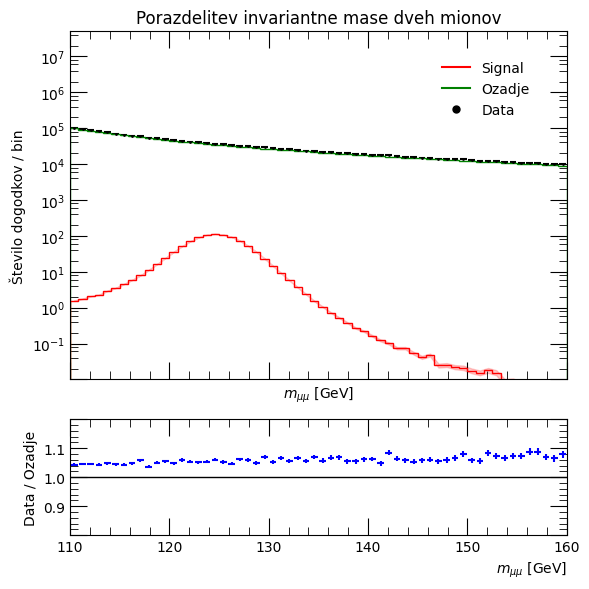

In [14]:
# using helpers
from helpers.visualize_data import visualize_histograms

visualize_histograms(hists.keys(), save_hist_name, "data/generated_histograms/", output_filename=None, save=False)
plt.tight_layout()

In [ ]:
import numpy as np
from uncertainties import unumpy as unp

def minmax_normalize(X, y):
    """
    Izvede min-max normalizacijo vhodov X in izhodov y (lahko z napakami).

    Parametri:
    ----------
    X : unp.uarray, shape (n_samples, 1)
        Vhodne vrednosti (npr. bin centri)
    y : unp.uarray ali unumpy.uarray
        Izhodne vrednosti (lahko z napakami)

    Vrne:
    -----
    X_norm : np.ndarray
        Normalizirani vhodi
    y_norm : np.ndarray
        Normalizirane nominalne vrednosti y
    params : dict
        Parametri za kasnejšo inverzno transformacijo (x_min, x_max, y_min, y_max)
    """

    # --- Če y vsebuje napake (unumpy array) ---
    y_nom = unp.nominal_values(y)

    # --- Normalizacija ---
    x_min, x_max = np.min(X), np.max(X)
    y_min, y_max = np.min(y_nom), np.max(y_nom)

    X_norm = (X - x_min) / (x_max - x_min)
    y_norm = (y - y_min) / (y_max - y_min)

    params = {"x_min": x_min, "x_max": x_max, "y_min": y_min, "y_max": y_max}

    return X_norm, y_norm, params


def minmax_inverse(X_norm, y_norm, params):
    """
    Obrne min-max normalizacijo nazaj v originalne enote.

    Parametri:
    ----------
    X_norm, y_norm : np.ndarray
        Normalizirani podatki
    params : dict
        Slovar z mejami: {"x_min", "x_max", "y_min", "y_max"}

    Vrne:
    -----
    X, y, y_std : np.ndarray
        Nenormalizirani podatki
    """

    X = X_norm * (params["x_max"] - params["x_min"]) + params["x_min"]
    y = y_norm * (params["y_max"] - params["y_min"]) + params["y_min"]

    return X, y


def standard_normalize(X, y):
    """
    Izvede standardno normalizacijo vhodov X in izhodov y (z upoštevanjem napak).

    Parametri:
    ----------
    X : unp.uarray, shape (n_samples, 1)
        Vhodne vrednosti (npr. bin centri)
    y : unp.uarray ali unumpy.uarray
        Izhodne vrednosti (lahko z napakami)

    Vrne:
    -----
    X_norm : unp.uarray
        Normalizirani vhodi
    y_norm : unp.uarray
        Normalizirane vrednosti y
    params : dict
        Parametri za inverzno transformacijo (x_mean, x_std, y_mean, y_std)
    """

    y_nom = unp.nominal_values(y)

    # --- Normalizacija ---
    x_mean, x_std = np.mean(X), np.std(X)
    y_mean, y_std_nom = np.mean(y_nom), np.std(y_nom)

    X_norm = (X - x_mean) / x_std
    y_norm = (y - y_mean) / y_std_nom

    params = {"x_mean": x_mean, "x_std": x_std,
              "y_mean": y_mean, "y_std": y_std_nom}
    
    return X_norm, y_norm, params


def standard_inverse(X_norm, y_norm, params):
    """
    Obrne standardno normalizacijo nazaj v originalne enote.

    Parametri:
    ----------
    X_norm, y_norm : unp.undarray
        Normalizirani podatki
    params : dict
        Slovar s povprečji in standardnimi odkloni

    Vrne:
    -----
    X, y : unp.uarray
        Nenormalizirani podatki
    """

    X = X_norm * params["x_std"] + params["x_mean"]
    y = y_norm * params["y_std"] + params["y_mean"]

    return X, y


def log_normalize(X, y):
    """
    Izvede logaritemsko normalizacijo vhodov X in izhodov y (z upoštevanjem napak).

    Parametri:
    ----------
    X : unp.uarray, shape (n_samples, 1)
        Vhodne vrednosti (npr. bin centri)
    y : unp.uarray
        Izhodne vrednosti (lahko z napakami)

    Vrne:
    -----
    X_norm : unp.uarray
        Normalizirani vhodi
    y_norm : unp.uarray
        Normalizirane nominalne vrednosti y
    params : dict
        Parametri za inverzno transformacijo (x_mean, x_std, y_mean, y_std)
    """

    # --- Normalizacija ---
    X_norm = np.log(X)
    y_norm = unp.log(y)
    
    params = {}

    return X_norm, y_norm, params


def log_inverse(X_norm, y_norm, params):
    """
    Obrne standardno normalizacijo nazaj v originalne enote.

    Parametri:
    ----------
    X_norm, y_norm : unp.uarray
        Normalizirani podatki

    Vrne:
    -----
    X, y : unp.uarray
        Nenormalizirani podatki
    """

    X = unp.exp(X_norm)
    y = unp.exp(y_norm)

    return X, y


def normalize(X, y, type):
    """
    Noamrlizira podatke za par različnih tipov normalizacije

    Parametri:
    ----------
    X : unp.uarray, shape (n_samples, 1)
        Vhodne vrednosti (npr. bin centri)
    y : unp.uarray
        Izhodne vrednosti (lahko z napakami)
    type : str
        Tip normalizacije "minmax", "standard", "log"
    
    Vrne:
    -----
    X_norm : unp.uarray
        Normalizirani vhodi
    y_norm : unp.uarray
        Normalizirane nominalne vrednosti y
    params : dict
        Parametri za inverzno transformacijo (x_mean, x_std, y_mean, y_std)
    """

    if type == "minmax":
        X_norm, y_norm, params = minmax_normalize(X, y)
        return X_norm, y_norm, params
    
    elif type == "standard":
        X_norm, y_norm, params = standard_normalize(X, y)
        return X_norm, y_norm, params
    
    elif type == "log":
        X_norm, y_norm, params = log_normalize(X, y)
        return X_norm, y_norm, params
    
    else:
        return print("Tega tipa normalizacije ni v meniju.")
    

def denormalize(X_norm, y_norm, params, type):
    """
    Denoamrlizira podatke za par različnih tipov denormalizacije

    Parametri:
    ----------
    X_norm, y_norm : unp.undarray
        Normalizirani podatki
    params : dict
        Slovar s potrebnimi parametri
    type : str
        Tip normalizacije "minmax", "standard", "log"
    
    Vrne:
    -----
    X, y : unp.uarray
        Nenormalizirani podatki
    """

    if type == "minmax":
        X, y = minmax_inverse(X_norm, y_norm, params)
        return X, y
    
    elif type == "standard":
        X, y = standard_inverse(X_norm, y_norm, params)
        return X, y
    
    elif type == "log":
        X, y = log_inverse(X_norm, y_norm, params)
        return X, y
    
    else:
        return print("Tega tipa denormalizacije ni v meniju.")
    

In [24]:
x = np.arange(1, 7)
y = np.array([1, 1, 2, 2, 1, 3])
yerr = np.array([0.1, 0.15, 0.2, 0.2, 0.1, 0.25])
y = unp.uarray(y, yerr)

print(x)
print(y)
print('-------------------------------')

x_norm, y_norm, params = log_normalize(x, y)

print(x_norm)
print(y_norm)
print('-------------------------------')

X, Y = log_inverse(x_norm, y_norm, params)

print(X)
print(Y)
print('-------------------------------')

[1 2 3 4 5 6]
[1.0+/-0.1 1.0+/-0.15 2.0+/-0.2 2.0+/-0.2 1.0+/-0.1 3.0+/-0.25]
-------------------------------
[0.         0.69314718 1.09861229 1.38629436 1.60943791 1.79175947]
[0.0+/-0.1 0.0+/-0.15 0.6931471805599453+/-0.1 0.6931471805599453+/-0.1
 0.0+/-0.1 1.0986122886681098+/-0.08333333333333333]
-------------------------------
[1.0 2.0 3.0000000000000004 4.0 4.999999999999999 6.0]
[1.0+/-0.1 1.0+/-0.15 2.0+/-0.2 2.0+/-0.2 1.0+/-0.1
 3.0000000000000004+/-0.25]
-------------------------------
